In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from scipy.stats import boxcox
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## ARIMA

Возьмем ряд со средней месячной температурой воздуха

In [4]:
mean_monthly_temp = pd.read_csv("../1/Series/mean-monthly-air-temperature-deg.csv")["Deg"]

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


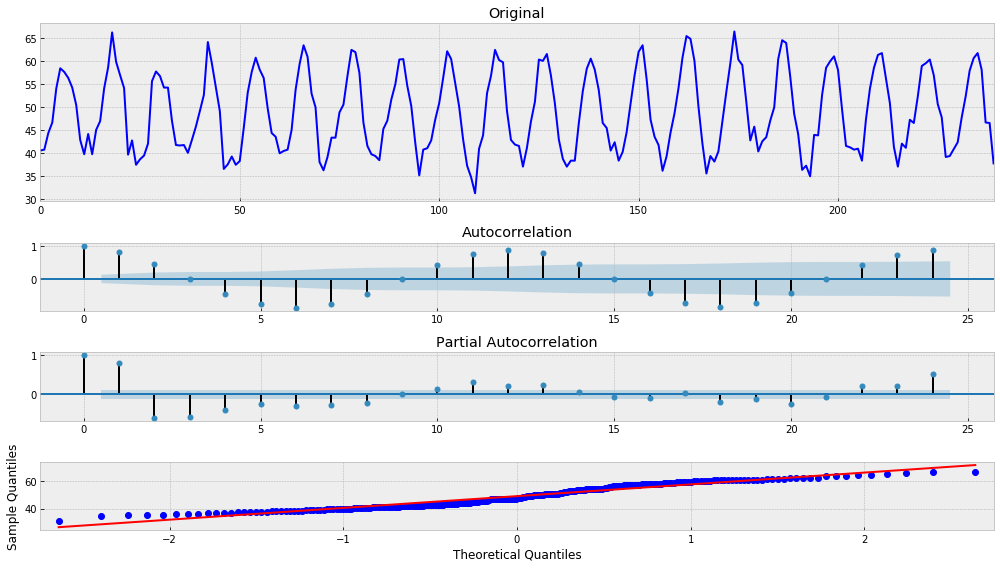

In [5]:
tsplot(mean_monthly_temp)

Как видно, ряд не стационарен и обладает ярко выраженной сезонностью. Применим к нему модель ARIMA с поиском наилучших значений параметров

In [6]:
mean_monthly_temp = boxcox(mean_monthly_temp, 0)
mean_monthly_temp = mean_monthly_temp[12:] - mean_monthly_temp[:-12]

aic: -552.84903 | order: (4, 0, 3)
Results of Dickey-Fuller Test:
Test Statistic                  -5.338306
p-value                          0.000005
#Lags Used                      15.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


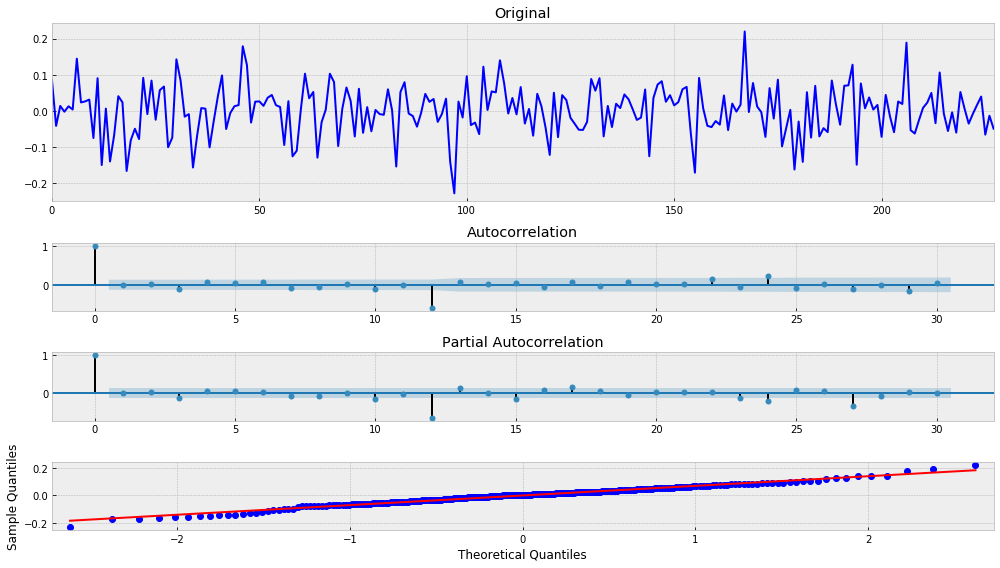

In [7]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(mean_monthly_temp, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

Теперь остатки стали стаицонарными, следовательно, модели удалось хорошо описать ряд. Значение критерия Акаике равно -1164, значения параметров ARIMA (p, d, q) = (4, 0, 4)

Спрогнозируем с помощью полученной модели ряд на 20 значений вперед

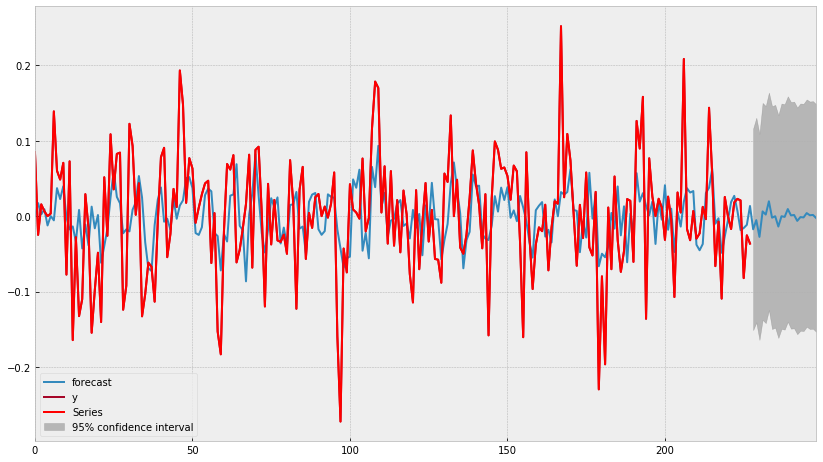

In [8]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    best_mdl.plot_predict(0, len(mean_monthly_temp) + 20, ax=ax)
    plt.plot(mean_monthly_temp, color='red', label='Series')
    plt.legend()
    plt.show()

Как видно, в целом модель не очень хорошо описала ряд, особенно резкие пики. Предсказанные значения со временем угасают.

## GARCH

In [9]:
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

am = arch_model(mean_monthly_temp, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     70,   Neg. LLF: -264.42750334827804
Iteration:     10,   Func. Count:    134,   Neg. LLF: -265.31420832241247
Iteration:     15,   Func. Count:    194,   Neg. LLF: -265.51496430260795
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -265.51557673729496
            Iterations: 19
            Function evaluations: 242
            Gradient evaluations: 19
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                265.516
Distribution:      Standardized Student's t   AIC:                          -511.031
Method:                  Maximum Likelihood   BIC:                          -476.738
                                              No. Obser

Results of Dickey-Fuller Test:
Test Statistic                -6.411725e+00
p-value                        1.883599e-08
#Lags Used                     1.200000e+01
Number of Observations Used    2.150000e+02
Critical Value (1%)           -3.461136e+00
Critical Value (5%)           -2.875079e+00
Critical Value (10%)          -2.573986e+00
dtype: float64


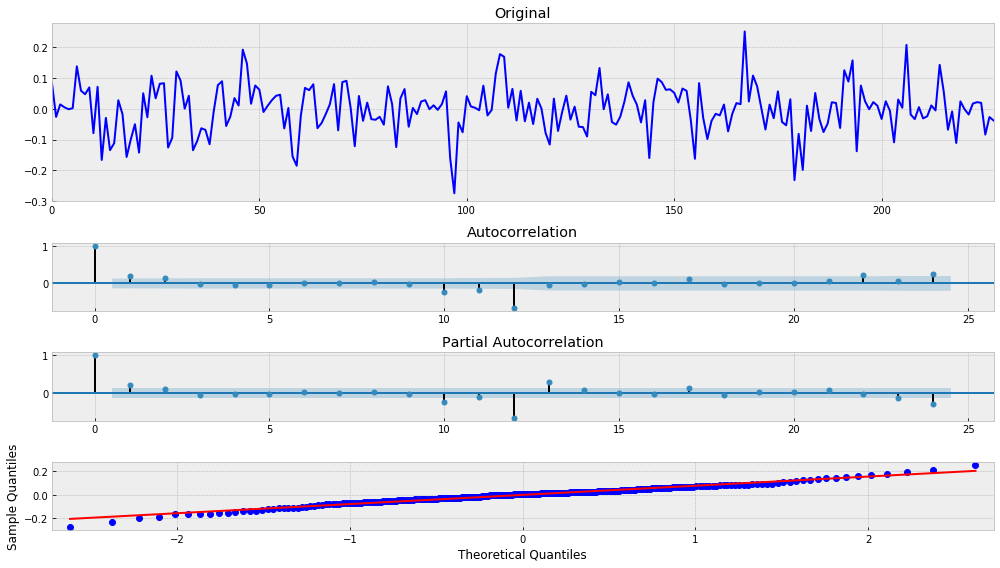

In [10]:
tsplot(res.resid)

Остатки модели GARCH также стационарны, а значение критерия Акаике равно -1117.8, что немного больше, чем у предыдущей модели ARIMA. Следовательно, исходя из критерия, в данном случае лучше использовать предыдущую модель ARIMA.

## Классический ML

In [11]:
series = pd.read_csv("../1/Series/mean-monthly-air-temperature-deg.csv")

In [12]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Deg.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Deg"], axis=1)
    y_train = data.loc[:test_index]["Deg"]
    X_test = data.loc[test_index:].drop(["Deg"], axis=1)
    y_test = data.loc[test_index:]["Deg"]
    
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

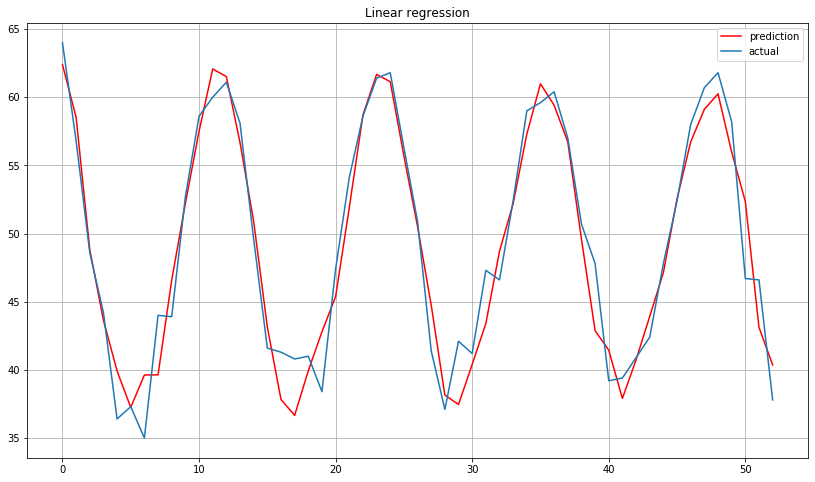

In [14]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

Без особой настройки модели и фич простая линейная регрессия в целом неплохо справляется и "улавливает" основное поведение ряда. 